<div class="alert alert-block alert-success"><font color="black"><h1><left>Create MIMIC Model for Four Intestinal Conditions<P>
    - This notebook uses medicalai/ClinicalBert 5-3-2023</left></h1></font></div>

In [1]:
#Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

In [2]:
# Connect to AWS
import boto3
import uuid
import s3fs
import os

from kaggle_secrets import UserSecretsClient

user_secrets = UserSecretsClient()
aws_id = user_secrets.get_secret("aws_access_key_id")
aws_key = user_secrets.get_secret("aws_secret_access_key")
aws_region = user_secrets.get_secret("aws_region")

#If the Secrets Add-on works properly, we will see the current region here
# By the way, we do not need a region, because S3 allows us to create Global buckets too

print('aws region: ', aws_region)

fs = s3fs.S3FileSystem(
    anon=False,
    use_ssl=True,
    client_kwargs={
        "region_name": aws_region,
        "aws_access_key_id": aws_id,
        "aws_secret_access_key": aws_key,
        "verify": True,
    }
)


aws region:  us-east-1


In [3]:
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:256"


In [4]:
path = 's3://depratti-masters-thesis/MIMIC/Data/'
file1 = path + 'intsl_train_indiv_no2.snappy.parquet'
file2 = path + 'intsl_test_indiv_no2.snappy.parquet'
file3 = path + 'intsl_val_indiv_no2.snappy.parquet'

In [5]:
from datasets import Dataset,Features,Value,ClassLabel
import pyarrow.parquet as pq

intsl_train = pq.ParquetDataset(file1, filesystem=fs).read_pandas().to_pandas()
#intsl_train = intsl_train[intsl_train.text.str.len() <= 17000]
print('completed ', intsl_train.shape)
# intsl_train = reduce_mem_usage(intsl_train)
intsl_train.columns

intsl_test = pq.ParquetDataset(file2, filesystem=fs).read_pandas().to_pandas()
# intsl_test = intsl_test[intsl_test.text.str.len() <= 17000]
print('completed ', intsl_test.shape)

intsl_val = pq.ParquetDataset(file3, filesystem=fs).read_pandas().to_pandas()
# intsl_val = intsl_val[intsl_val.text.str.len() <= 17000]
print('completed ', intsl_val.shape)

intsl_full_valid = pd.concat([intsl_test, intsl_val])
print('completed ', intsl_full_valid.shape)


completed  (300, 4)
completed  (42, 4)
completed  (42, 4)
completed  (84, 4)


In [6]:
intsl_train.groupby('label')['id'].count()

label
0    75
1    75
2    75
3    75
Name: id, dtype: int64

In [7]:
"""  Will start with removing this filter
# remove heart and reflex
## Special code to drop categoriues and renumber labeles
# Not needed all the time

def convert_label(label):
    
    if label == 2:
        return(0)
    elif label == 3:
        return(1)
    elif label == 4:
        return(2)
    else:
        return(label)
    
intsl_train = intsl_train[intsl_train.labels.isin([2,3,4])]
intsl_train['labels'] = intsl_train.labels.map(lambda x: convert_label(x)) 
intsl_val = intsl_val[intsl_val.labels.isin([2,3,4])]
intsl_val['labels'] = intsl_val.labels.map(lambda x: convert_label(x)) 
intsl_test = intsl_test[intsl_test.labels.isin([2,3,4])]
intsl_test['labels'] = intsl_test.labels.map(lambda x: convert_label(x)) 
print(intsl_train.count())
print(intsl_test.count())
print(intsl_val.count())
print(intsl_train.groupby('label')['id'].count())
print(intsl_test.groupby('label')['id'].count())
print(intsl_val.groupby('label')['id'].count())
"""

"  Will start with removing this filter\n# remove heart and reflex\n## Special code to drop categoriues and renumber labeles\n# Not needed all the time\n\ndef convert_label(label):\n    \n    if label == 2:\n        return(0)\n    elif label == 3:\n        return(1)\n    elif label == 4:\n        return(2)\n    else:\n        return(label)\n    \nintsl_train = intsl_train[intsl_train.labels.isin([2,3,4])]\nintsl_train['labels'] = intsl_train.labels.map(lambda x: convert_label(x)) \nintsl_val = intsl_val[intsl_val.labels.isin([2,3,4])]\nintsl_val['labels'] = intsl_val.labels.map(lambda x: convert_label(x)) \nintsl_test = intsl_test[intsl_test.labels.isin([2,3,4])]\nintsl_test['labels'] = intsl_test.labels.map(lambda x: convert_label(x)) \nprint(intsl_train.count())\nprint(intsl_test.count())\nprint(intsl_val.count())\nprint(intsl_train.groupby('label')['id'].count())\nprint(intsl_test.groupby('label')['id'].count())\nprint(intsl_val.groupby('label')['id'].count())\n"

In [8]:
intsl_train.columns

Index(['id', 'text', 'icd10_code', 'label'], dtype='object')

In [9]:
print(len(intsl_train['id'].unique()))
intsl_train = intsl_train[['text', 'label']]
intsl_full_valid = intsl_full_valid[['text', 'label']]
intsl_val = intsl_val[['text', 'label']]


print(intsl_train.shape)
print(intsl_full_valid.shape)
print(intsl_val.shape)
print(intsl_train.columns)
print(intsl_full_valid.columns)
print(intsl_val.columns)



217
(300, 2)
(84, 2)
(42, 2)
Index(['text', 'label'], dtype='object')
Index(['text', 'label'], dtype='object')
Index(['text', 'label'], dtype='object')


In [10]:
# Create a hugging face dataset from input dataframes
# https://discuss.huggingface.co/t/class-labels-for-custom-datasets/15130

import datasets
from datasets import Dataset, DatasetDict, Value, ClassLabel, Features

dfeatures = Features({'text': Value(dtype='string'),\
                      'label': ClassLabel(num_classes=4, names=['K51.90','K29.90','K21.9', 'I27.89'])})

notes_ds = DatasetDict({
    "train": Dataset.from_pandas(intsl_train.reset_index(drop=True),features=dfeatures),
    "valid": Dataset.from_pandas(intsl_full_valid.reset_index(drop=True),features=dfeatures)})

    
#    "test": Dataset.from_pandas(intsl_test.reset_index(drop=True),features=dfeatures)})
, 
# notes_ds['train'] = notes_ds['train'].class_encode_column("labels")
# notes_ds['test'] = notes_ds['test'].class_encode_column("labels")
# notes_ds['valid'] = notes_ds['valid'].class_encode_column("labels")


notes_ds

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 300
    })
    valid: Dataset({
        features: ['text', 'label'],
        num_rows: 84
    })
})

In [11]:
temp_df = notes_ds['valid'].to_pandas()
temp_df.groupby('label').count()
# intsl_val.groupby('label').count()

,text
label,
0,22
1,18
2,22
3,22


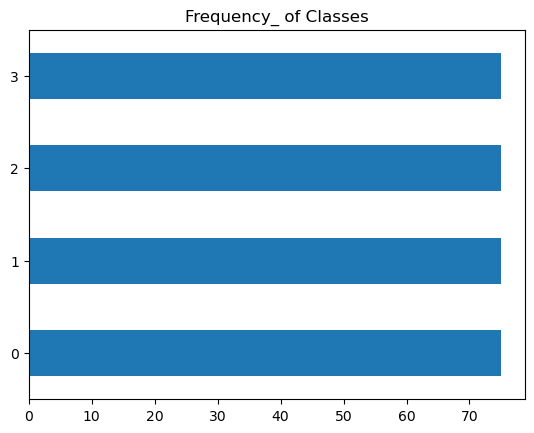

In [12]:
# Examine balancing between classes
new_df = notes_ds['train'].to_pandas()
new_df['label'].value_counts(ascending=False).plot.barh()
plt.title('Frequency_ of Classes')
plt.show()

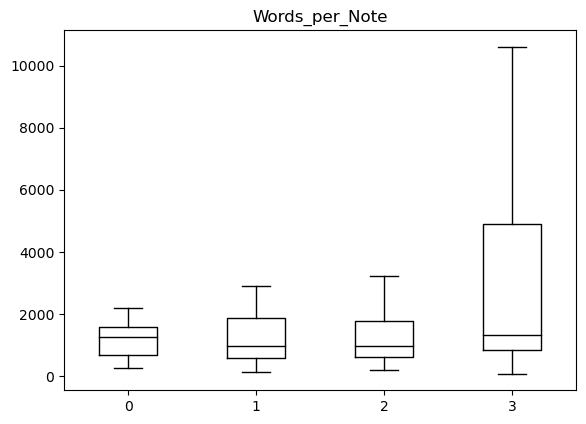

In [13]:
# This shows that I may need to adjust word counts on text for balance
# This should be moved into setup with mitigation balanciong by note size
new_df['Words_per_Note'] = new_df["text"].str.split().apply(len)
new_df.boxplot('Words_per_Note', by='label', grid=False, showfliers=False, color='black')
plt.suptitle('')
plt.xlabel("")
plt.show()


In [14]:
new_df[1:5]

,text,label,Words_per_Note
1,micu nursing progress note. - please see carev...,0,770
2,tsicu nursing progress note neuro: pt a&o x pt...,0,882
3,respiratory care: pt. intubated secondary to w...,0,1574
4,ccu nursing progress note pls see fhpa for det...,0,1259


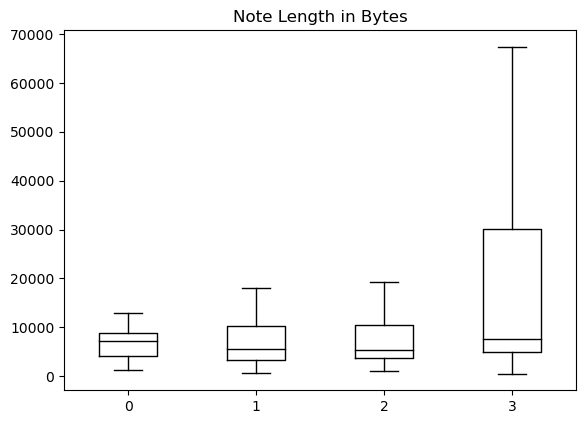

In [15]:
# This shows whether we need to adjust word counts on text for balance
# This should be moved into setup with mitigation balanciong by note size
new_df['Note_length'] = new_df["text"].str.len()
new_df.boxplot('Note_length', by='label', grid=False, showfliers=False, color='black')
plt.title('Note Length in Bytes')
plt.suptitle('')
plt.xlabel("")
plt.show()


In [16]:
from transformers import AutoTokenizer, AutoModel, set_seed

set_seed(23)
# model_ckpt = 'bert-base-uncased'
model_ckpt = 'medicalai/ClinicalBERT'
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

In [17]:
def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True, max_length=256)


notes_enc = notes_ds.map(tokenize, batched=True,batch_size=None)

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [18]:
# Print encoded dataset format and conmponents
notes_enc
print(notes_enc['train'].column_names)

['text', 'label', 'input_ids', 'attention_mask']


In [19]:
# Load the pretrained ClinicalBert model 
import torch
from transformers import AutoModel

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_ckpt = 'medicalai/ClinicalBERT'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# num_labels = 2
model = AutoModel.from_pretrained(model_ckpt).to(device)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Some weights of the model checkpoint at medicalai/ClinicalBERT were not used when initializing DistilBertModel: ['vocab_projector.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [20]:
def extract_hidden_states(batch):
    # Place model inputs on the GPU
    inputs = {k:v.to(device) for k,v in batch.items() if k in tokenizer.model_input_names}
    temp = list(inputs.values())[0]
#    print('v : ' , type(temp), ' ', 'len: ', len(temp) )
    # Extract last hidden states
    with torch.no_grad():
        last_hidden_state = model(**inputs).last_hidden_state
    # Return vector for [CLS] token
    return {"hidden_state": last_hidden_state[:,0].cpu().numpy()}

notes_enc.set_format("torch", columns=["input_ids", "attention_mask", "label"])
# I had to change the commandin the book by adding the batch_size = 1. With that missing, I was getting a list has no to method
notes_hidden = notes_enc.map(extract_hidden_states, batched=True, batch_size=1)

notes_hidden["train"].column_names




  0%|          | 0/300 [00:00<?, ?ba/s]

  0%|          | 0/84 [00:00<?, ?ba/s]

['text', 'label', 'input_ids', 'attention_mask', 'hidden_state']

In [21]:
X_train = np.array(notes_hidden["train"]["hidden_state"])
X_valid = np.array(notes_hidden["valid"]["hidden_state"])
y_train = np.array(notes_hidden["train"]["label"])
y_valid = np.array(notes_hidden["valid"]["label"])
X_train.shape, X_valid.shape

((300, 768), (84, 768))

In [22]:
from umap import UMAP
from sklearn.preprocessing import MinMaxScaler
# Scale features to [0,1] range
X_scaled = MinMaxScaler().fit_transform(X_train)
# Initialize and fit UMAP
mapper = UMAP(n_components=2, metric="cosine").fit(X_scaled)
# Create a DataFrame of 2D embeddings
df_emb = pd.DataFrame(mapper.embedding_, columns=["X", "Y"])
df_emb["label"] = y_train
df_emb.head()

,X,Y,label
0,4.089881,10.158035,0
1,1.732833,16.386070,0
2,2.933462,15.581880,0
3,-0.166757,12.264835,0
4,2.915951,16.228203,0


In [23]:
# notes_ds["train"].features
# notes_ds["train"][1:3]


In [24]:
# labels = notes_ds["train"].features["label"].names
labels = ['K51.90','K29.90','K21.9', 'I27.89']
labels

['K51.90', 'K29.90', 'K21.9', 'I27.89']

In [25]:
print(labels)
notes_ds['train']

['K51.90', 'K29.90', 'K21.9', 'I27.89']


Dataset({
    features: ['text', 'label'],
    num_rows: 300
})

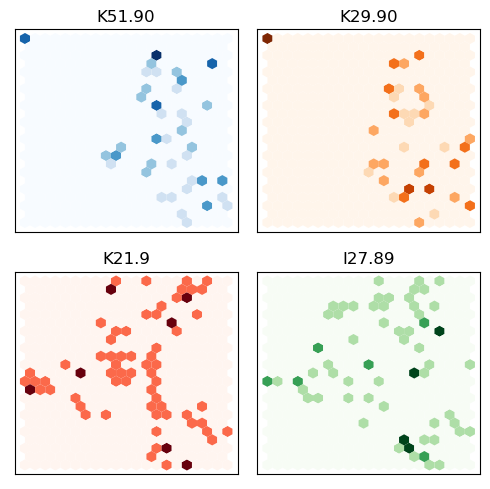

In [26]:
fig, axes = plt.subplots(2, 2, figsize=(5,5))
axes = axes.flatten()
cmaps = ["Blues","Oranges","Reds", "Greens"]
# labels = notes_ds["train"].features["label"].names
labels = ['K51.90','K29.90','K21.9','I27.89']
# labels = ['Colitis','Gastritis','Reflux', 'Heart']

for i, (label, cmap) in enumerate(zip(labels, cmaps)):
    df_emb_sub = df_emb.query(f"label == {i}")
    axes[i].hexbin(df_emb_sub["X"], df_emb_sub["Y"], cmap=cmap,
                   gridsize=20, linewidths=(0,))
    axes[i].set_title(label)
    axes[i].set_xticks([]), axes[i].set_yticks([])

# fig.delaxes(axes[3])
plt.tight_layout() 
plt.show()

In [27]:
#hide_output
# We increase `max_iter` to guarantee convergence 
from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression(max_iter=3000)
lr_clf.fit(X_train, y_train) 
lr_clf.score(X_valid, y_valid)

0.32142857142857145

In [28]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)
dummy_clf.score(X_valid, y_valid)

     

0.2619047619047619

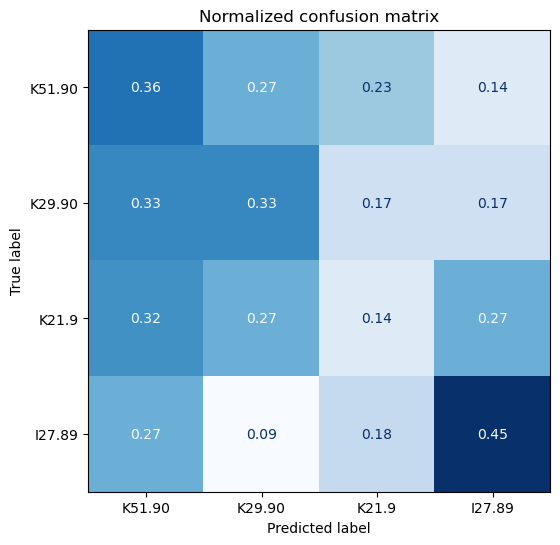

In [29]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# labels=['Colitis','Gastritis', 'Reflux','Heart']
labels = ['K51.90','K29.90','K21.9','I27.89']

def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()
    
y_preds = lr_clf.predict(X_valid)
plot_confusion_matrix(y_preds, y_valid, labels)
     

Text(0.5, 23.52222222222222, 'Predicted Values')

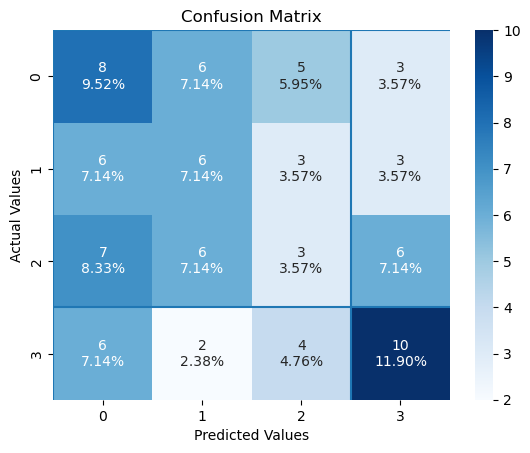

In [30]:
import seaborn as sns
cm = confusion_matrix(y_valid, y_preds)
group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]
labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_counts,group_percentages)]
labels = np.asarray(labels).reshape(4,4)
ax = sns.heatmap(cm, annot=labels, fmt='', cmap='Blues')
ax.hlines([0, 3], *ax.get_xlim())
ax.vlines([0, 3], *ax.get_xlim())
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')

In [31]:
from transformers import AutoModelForSequenceClassification

num_labels = 4
model = (AutoModelForSequenceClassification
         .from_pretrained(model_ckpt, num_labels=num_labels)
         .to(device))

Some weights of the model checkpoint at medicalai/ClinicalBERT were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at medicalai/ClinicalBERT and are newly initialized: ['classifier.bias', 'pre_classifier.bias', 'classifier.wei

In [32]:
from sklearn.metrics import accuracy_score, f1_score
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

In [33]:
from transformers import Trainer, TrainingArguments

batch_size = 64
logging_steps = len(notes_enc["train"]) // batch_size
model_name = f"{model_ckpt}_Intestinal"
training_args = TrainingArguments(output_dir=model_name,
                                  num_train_epochs=2,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  evaluation_strategy="epoch",
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  push_to_hub=True, 
                                  log_level="error")

In [34]:
from huggingface_hub import notebook_login
notebook_login()

In [36]:
# https://huggingface.co/learn/nlp-course/chapter3/3?fw=pt
from transformers import Trainer, DataCollatorWithPadding

#data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

trainer = Trainer(model=model, args=training_args, 
                  compute_metrics=compute_metrics,
                  train_dataset=notes_enc["train"],
                  eval_dataset=notes_enc["valid"],
                  tokenizer=tokenizer)
trainer.train();    

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Cloning https://huggingface.co/rdpratti/ClinicalBERT_Intestinal into local empty directory.


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

/opt/conda/lib/python3.7/site-packages/transformers/optimization.py:395: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


/opt/conda/lib/python3.7/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,1.388228,0.261905,0.108715
2,1.392100,1.388119,0.261905,0.108715


/opt/conda/lib/python3.7/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


In [37]:
# Make Predicts using the validation Data
preds_output = trainer.predict(notes_enc["valid"])
preds_output.metrics

/opt/conda/lib/python3.7/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'test_loss': 1.3881189823150635,
 'test_accuracy': 0.2619047619047619,
 'test_f1': 0.10871518418688231,
 'test_runtime': 0.441,
 'test_samples_per_second': 190.458,
 'test_steps_per_second': 2.267}

In [38]:
y_preds = np.argmax(preds_output.predictions, axis=1)
y_true = notes_enc['valid']['label']

In [39]:
y_preds

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [40]:
cross_table = pd.crosstab(y_true, y_preds, rownames=['Actual'], colnames=['Predicted'], margins=True)
cross_table

Predicted,2,All
Actual,,
0,22,22
1,18,18
2,22,22
3,22,22
All,84,84


Text(0.5, 23.52222222222222, 'Predicted Values')

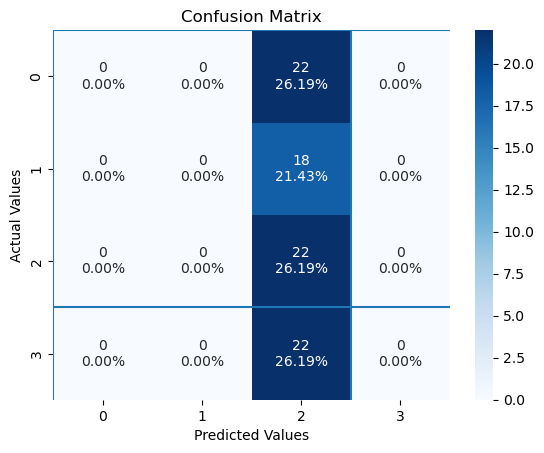

In [41]:
#Plotting the confusion matrix
import seaborn as sns
cm = confusion_matrix(y_true, y_preds)
group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]
labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_counts,group_percentages)]
labels = np.asarray(labels).reshape(4,4)
ax = sns.heatmap(cm, annot=labels, fmt='', cmap='Blues')
ax.hlines([0, 3], *ax.get_xlim())
ax.vlines([0, 3], *ax.get_xlim())
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')

In [42]:
#hide_output
#Convert our dataset back to PyTorch tensors

from torch.nn.functional import cross_entropy

def forward_pass_with_label(batch):
    # Place all input tensors on the same device as the model
    inputs = {k:v.to(device) for k,v in batch.items() 
              if k in tokenizer.model_input_names}

    with torch.no_grad():
        output = model(**inputs)
        pred_label = torch.argmax(output.logits, axis=-1)
        loss = cross_entropy(output.logits, batch["label"].to(device), 
                             reduction="none")

    # Place outputs on CPU for compatibility with other dataset columns   
    return {"loss": loss.cpu().numpy(), "predicted_label": pred_label.cpu().numpy()}
     

def label_int2str(in_number):
    label_dict = {0:'Colitis',1:'Gastritis', 2:'Reflux', 3:'Heart'}
    
    if in_number in label_dict:
        return label_dict.get(in_number)
    else: return 'dummy'
    
notes_enc.set_format("torch", columns=["input_ids", "attention_mask", "label"])
# Compute loss values
notes_enc["valid"] = notes_enc["valid"].map(forward_pass_with_label, batched=True, batch_size=1)

notes_enc.set_format("pandas")
cols = ["text", "label", "predicted_label", "loss"]
df_test = notes_enc["valid"][:][cols]
df_test["label"] = df_test["label"].apply(label_int2str)
df_test["predicted_label"] = (df_test["predicted_label"].apply(label_int2str))
     

  0%|          | 0/84 [00:00<?, ?ba/s]

In [43]:
#hide_output
sorted_output = df_test.sort_values("loss", ascending=False)
sorted_output['text'] = sorted_output['text'][0:20] 
sorted_output.groupby(['label','predicted_label']).count()

,,text,loss
label,predicted_label,,
Colitis,Reflux,20,22
Gastritis,Reflux,0,18
Heart,Reflux,0,22
Reflux,Reflux,0,22
